# Bias on Wikipedia

The goal of this project is to investigate and analyze bias in the quality and number of articles about politicians on Wikipedia, based on the nationality of the politicians. In our analysis, we will generate the following four tables:
1. Highest Politician Articles Per Capita
2. Lowest Politician Articles Per Capita
3. Highest Proportion of High Quality Politician Articles
4. Lowest Proportion of High Quality Politician Articles

Steps 1-9 are data collection and transformation. Skip to step 10 to perform the analysis.

# Step 1: Load data from Wikipedia dataset 

We sart by downloading data from the Wikipedia dataset for Polticians by Country from the English-language Wikipedia:
https://figshare.com/articles/Untitled_Item/5513449

Since this dataset has a CC-BY-SA 4.0 license, we have uploaded it to this repo with the filename "page_data.csv" for convenience.

In [312]:
import pandas as pd

wikipedia_data = pd.read_csv('page_data.csv')

# Step 2: Get article quality predictions from ORES

ORES (Objective Revision Evaluation Service) is exposed via a Wikimedia API endpoint. We will use this endpoint to evaluate the quality of the Wikipedia articles we loaded from Step #1. There are 6 categories of quality that ORES provide:
1. FA - Featured article
2. GA - Good article
3. B - B-class article
4. C - C-class article
5. Start - Start-class article
6. Stub - Stub-class article

For this analysis, we consider articles scored as "FA" or "GA" to be considered "high quality".

We start out by defining a method to retieve the ORES scores from the Wikimedia API. "get_ores_data" was copied from the following repository: https://github.com/Ironholds/data-512-a2

In [1]:
import requests
import json

headers = {'User-Agent' : 'https://github.com/murtazajafferji', 'From' : 'murtaza@uw.edu'}

# Multiple ids can be passed. ORES recommends a batch size of 50
def get_ores_data(revision_ids, headers):
    
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    
    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)
              }
    api_call = requests.get(endpoint.format(**params))
    return api_call.json()

We can now use "get_ores_data" to create a dictionary of revision ids to the score assigned by ORES. We break up the revision ids into groups of size ~ 50. ORES recommend a batch size of 50 ids. This number serves us well because it's big enough to limit the number of requests made to the API and small enough to keep us from hitting errors due to the URI request or JSON response being too large. Note: This is a long running method. Skip to step 4 if you'd like to load the data from a file instead of putting unnecessary strain on the API.

In [5]:
import math
import numpy as np
# This dictionary will store the revision id as the key and the ORES score as the value
# We'll use this dictonary to join the ORES score to the Wikipedia dataset
rev_id_ores_score_dict = {}
revision_ids = wikipedia_data.rev_id.tolist()
batch_size = 50

# np.array_split takes as a parameter the number of equally sized sub-arrays into we'd like to split the list
number_of_batches = math.ceil(len(revision_ids)/batch_size)
revision_id_batches = np.array_split(revision_ids, number_of_batches)

for revision_id_batch in revision_id_batches:
    ores_data = get_ores_data(revision_id_batch, headers)
    for rev_id, score in ores_data['enwiki']['scores'].items():
        wp10 = score['wp10']
        # 'score' won't be in wp10 if there was an error retrieving the revision from the API
        if 'score' in wp10:
            predicted_quality_score = wp10['score']['prediction']
            rev_id_ores_score_dict[rev_id] = predicted_quality_score

# Step 3: Join ORES data with Wikipedia dataset and save combined dataset to file

Now that we have the dictionary of revision ids to scores, we can add a column to the original Wikipedia dataset with the ORES scores. Note: A value of None means that the revision id was not found by ORES.

In [289]:
wikipedia_data_with_ores_score = wikipedia_data.copy()
wikipedia_data_with_ores_score['predicted_quality_score'] = wikipedia_data_with_ores_score.apply(lambda row: rev_id_ores_score_dict.get(str(row.rev_id)), axis=1)

We write the data to a file so that the data can be stored locally and we won't need to hit the API when running this notebook again.

In [313]:
wikipedia_data_with_ores_score.to_csv('wikipedia_data_with_ores_score.csv', index=False)

# Step 4: Load combined Wikipedia/ORES dataset from file
This step is only necessary if steps 2 and 3 were skipped.

In [314]:
wikipedia_data_with_ores_score = pd.read_csv('wikipedia_data_with_ores_score.csv')

# Step 5: Clean and transform combined dataset to get counts of artciles by country and quality articles by country

We first will stip out all articles not categorized by ORES.

In [132]:
wikipedia_data_with_ores_score_filtered =  wikipedia_data_with_ores_score[pd.notnull(wikipedia_data_with_ores_score['predicted_quality_score'])]

Next, we create a column called "quality" that will be 1 if the article is categorized as either "FA" or "GA" and 0 otherwise. We choose 1 and 0 instead of True/False because the quality column will be grouped by country and summed.

In [133]:
wikipedia_data_with_quality = wikipedia_data_with_ores_score_filtered.copy()
quality_scores = ['FA', 'GA']
wikipedia_data_with_quality['quality'] = wikipedia_data_with_ores_score_filtered.apply(lambda row: 1 if row.predicted_quality_score in quality_scores else 0, axis=1)

Finally, we group by country and create columns for "article count" and "quality count".

In [ ]:
article_count_by_country = wikipedia_data_with_quality.groupby(['country']).size().reset_index(name='article count')
quality_count_by_country = wikipedia_data_with_quality.groupby(['country'])['quality'].agg(['sum']).rename(columns={'sum': 'quality count'})

# Join on the 'country' column
counts_by_country = pd.merge(article_count_by_country, quality_count_by_country, on='country')

# Step 6: Load the population dataset


We can now download a world population dataset (as of mid-2018), that is stored on Dropbox:
https://www.dropbox.com/s/5u7sy1xt7g0oi2c/WPDS_2018_data.csv?dl=0

Since this dataset does not have a license associated with it, we have uploaded it to this repo with the filename "WPDS_2018_data.csv" for convenience, in accordance to  Dropbox's sitewide copyright policy.

In [ ]:
population_data = pd.read_csv('WPDS_2018_data.csv')


# Step 7: Analyze Wikipeda dataset and population dataset to fix inconsistencies

We can now look at this population dataset and find that there are inconsistencies between how some countries are named vs how they are named in the Wikipedia dataset. Using a manual process, we can create a mapping file of values that need to be renamed in the population dataset in the Geography column.

In [291]:
# The key is the current value in the population dataset and the value is the corresponding value in the Wikipedia dataset
country_map = {'Congo, Dem. Rep.': 'Congo, Dem. Rep. of',
      'El Salvador': 'Salvadoran',
      'Honduras': 'Hondura',
      'St. Kitts-Nevis': 'Saint Kitts and Nevis',
      'Saint Lucia': 'Saint Lucian',
       'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
       'Oman': 'Omani',
       'Timor-Leste': 'East Timorese',
       'Czechia': 'Czech Republic',
       'Palaun': 'Palauan',
       'Samoa': 'Samoan'
      }


cleaned_population_data = population_data.replace({"Geography": country_map})

# Step 8: Convert population column from string to float in order to enable sorting

We now convert the "Population mid-2018 (millions)" column from string to float and rename the column to "population (millions)" for convenience.

In [ ]:
cleaned_population_data['population (millions)'] = cleaned_population_data['Population mid-2018 (millions)'].replace(',','', regex=True).astype(float)
cleaned_population_data = cleaned_population_data.drop('Population mid-2018 (millions)', 1)


# Step 9: Merge transformed dataset from Step #5 with cleaned population dataset and save to file

We will join the "Geography" columm from the population dataset with the "country" column of the transformed dataset. Note: This join will remove any countries that don't exact matches in each dataset.

In [316]:
counts_by_country_with_population = pd.merge(counts_by_country, cleaned_population_data, left_on = 'country', right_on = 'Geography')
counts_by_country_with_population = counts_by_country_with_population.drop('Geography', 1)
counts_by_country_with_population.to_csv('politician_article_counts_by_country_with_population.csv', index=False)

# Step 10: Load data from the merged and curated dataset
Load data from the curated dataset we genrated from steps 1-9.

In [ ]:
counts_by_country_with_population_and_proportions = pd.read_csv('politician_article_counts_by_country_with_population.csv')

# Step 11: Add columns needed for analysis
We will add two columns to our dataset, which will be used to sort the countries based on coverage and quality. The first is "article count over country population" and the second is "quality count over article count".

In [307]:
counts_by_country_with_population_and_proportions['article count over country population'] = counts_by_country_with_population_and_proportions['article count']/counts_by_country_with_population_and_proportions['population (millions)']
counts_by_country_with_population_and_proportions['quality count over article count'] = counts_by_country_with_population_and_proportions['quality count']/counts_by_country_with_population_and_proportions['article count']

# Step 12: Sort dataframe based on columns and create dataframes needed for visualizing results
We create a method called "process_table_for_analysis", which will sort the final dataset based on the proportion columns defined in Step 11 and add a rank column. We then create dataframes that will be used to generate our table images.

In [308]:
def process_table_for_analysis(df, sort_column, select_columns, ascending=True):
    df_processed = df.copy()
    df_processed = df_processed.sort_values(sort_column, ascending=ascending) # Sort based on the columns specified
    df_processed = df_processed.loc[:,select_columns] # Select columns desired for table image
    df_processed = df_processed.reset_index(drop=True)  # Remove default index
    df_processed.insert(0,'rank',np.arange(1, len(df_processed) + 1))  # Add a rank column that starts at 1

    return df_processed

# 10 highest-ranked countries in terms of number of politician articles as a proportion of country population
highest_politician_articles_per_capita = process_table_for_analysis(counts_by_country_with_population_and_proportions, 'article count over country population', ['country', 'population (millions)', 'article count'], ascending=False)

# 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population
lowest_politician_articles_per_capita = process_table_for_analysis(counts_by_country_with_population_and_proportions, 'article count over country population', ['country', 'population (millions)', 'article count'])

# 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
highest_proportion_high_quality = process_table_for_analysis(counts_by_country_with_population_and_proportions, 'quality count over article count', ['country', 'article count', 'quality count'], ascending=False)

# 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
lowest_proportion_high_quality = process_table_for_analysis(counts_by_country_with_population_and_proportions, ['quality count over article count', 'article count'], ['country', 'article count', 'quality count'], ascending=[True, False])


# Step 13: Create method for turning dataframe into styled table image
We found a create code snippet from StackOverflow to visualize dataframes, which is pasted and slightly modified below:
https://stackoverflow.com/questions/19726663/how-to-save-the-pandas-dataframe-series-data-as-a-figure/39358752#39358752

In [317]:
import matplotlib.pyplot as plt
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, filename=None, title=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    if title is not None:
        ax.set_title(title, fontsize=14, fontweight='bold')
        
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
            
    if filename is not None:
        fig = ax.get_figure()
        fig.savefig(filename)
    return ax



# Step 14: Create image files for tables to summarize analysis
1. 10 Highest Politician Articles Per Capita
2. 10 Lowest Politician Articles Per Capita
3. 10 Highest Proportion of High Quality Politician Articles
4. 10 Lowest Proportion of High Quality Politician Articles

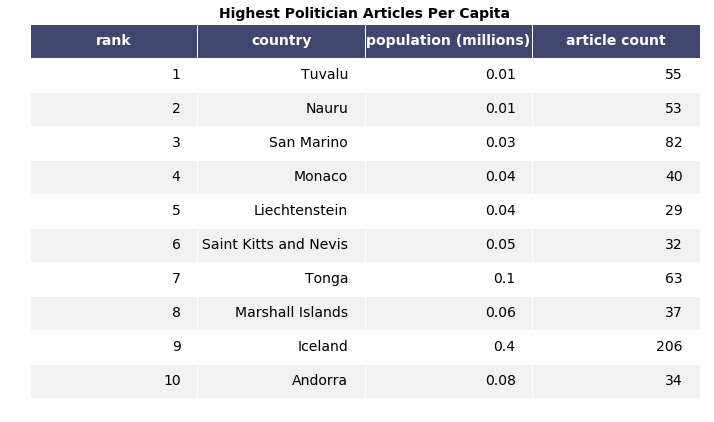

In [321]:
render_mpl_table(highest_politician_articles_per_capita.head(10), title="Highest Politician Articles Per Capita", filename='highest_politician_articles_per_capita.png');

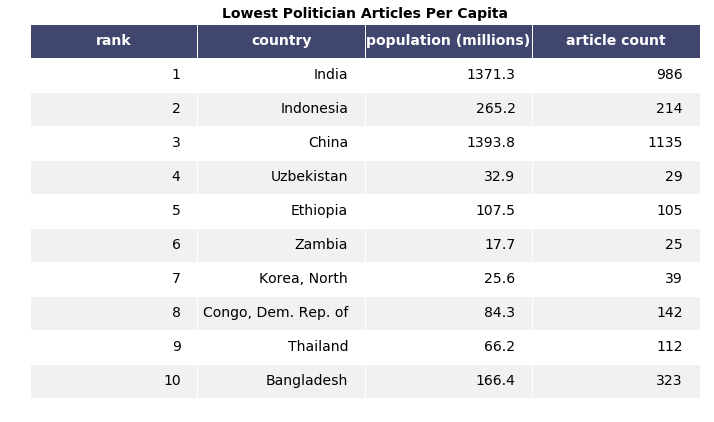

In [320]:
render_mpl_table(lowest_politician_articles_per_capita.head(10), title="Lowest Politician Articles Per Capita", filename='lowest_politician_articles_per_capita.png');

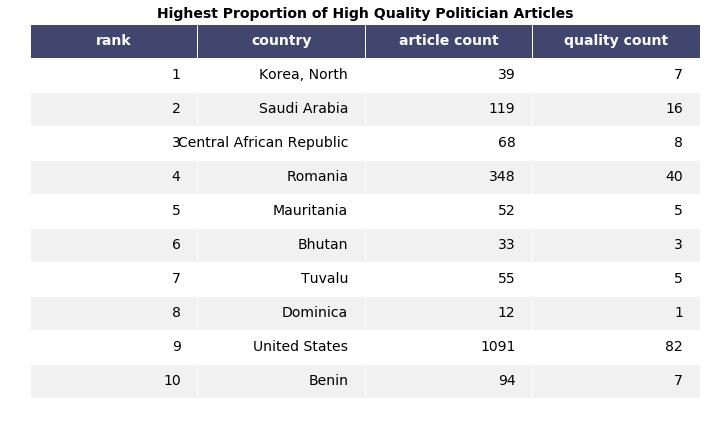

In [319]:
render_mpl_table(highest_proportion_high_quality.head(10), title="Highest Proportion of High Quality Politician Articles", filename='highest_proportion_high_quality.png');

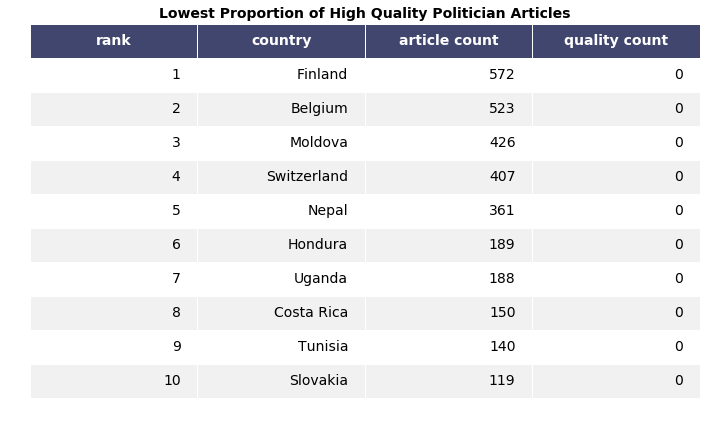

In [318]:
render_mpl_table(lowest_proportion_high_quality.head(10), title="Lowest Proportion of High Quality Politician Articles", filename='lowest_proportion_high_quality.png');